In [1]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import scipy as sp
import cvxpy as cp
import warnings
import datetime
warnings.filterwarnings('ignore')
import quandl
import matplotlib.pyplot as plt
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_ns_ols,calibrate_nss_ols
import seaborn as sns
from sklearn.decomposition import PCA
import statsmodels as smo
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import pyflux as pf
from statsmodels.tsa.vector_ar.var_model import VAR, VARProcess, VARResults
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen, select_order

In [2]:
import h2o
from h2o.estimators import H2OGeneralizedLowRankEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.7+8-LTS, mixed mode)
  Starting server from C:\Users\arnab\anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\arnab\AppData\Local\Temp\tmpg5t3lu16
  JVM stdout: C:\Users\arnab\AppData\Local\Temp\tmpg5t3lu16\h2o_arnab_started_from_python.out
  JVM stderr: C:\Users\arnab\AppData\Local\Temp\tmpg5t3lu16\h2o_arnab_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------------
H2O_cluster_uptime:         04 secs
H2O_cluster_timezone:       America/Los_Angeles
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.30.0.4
H2O_cluster_version_age:    5 months and 14 days !!!
H2O_cluster_name:           H2O_from_python_arnab_t1i7aj
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    1.475 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         accepting new members, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.7.6 final
--------------------------  ---------------------------------------------------------

In [3]:
## Interest rate measures
### Treasury Data
dgs_1yr = pd.read_excel("DGS1.xls",skiprows=10,index_col=0) ## 1 Yr Treasury Data
dgs_2yr = pd.read_excel("DGS2.xls",skiprows=10,index_col=0) ## 2 Yr Treasury Data
dgs_5yr = pd.read_excel("DGS5.xls",skiprows=10,index_col=0) ## 5 Yr Treasury Data
dgs_10yr = pd.read_excel("DGS10.xls",skiprows=10,index_col=0) ## 10 Yr Treasury Data
dgs_20yr = pd.read_excel("DGS20.xls",skiprows=10,index_col=0) ## 20 Yr Treasury Data

dgs_1yr = dgs_1yr.resample('MS').mean()
dgs_2yr = dgs_2yr.resample('MS').mean()
dgs_5yr = dgs_5yr.resample('MS').mean()
dgs_10yr = dgs_10yr.resample('MS').mean()
dgs_20yr = dgs_20yr.resample('MS').mean()

### T Bill Data
dtb_1M = pd.read_excel("TB4WK.xls",skiprows=10,index_col=0) ## 1M T Bill, commented due to lack of dataseries avaiability prior to 2001
dtb_3M = pd.read_excel("TB3MS.xls",skiprows=10,index_col=0) ## 3M T Bill
dtb_6M = pd.read_excel("DTB6.xls",skiprows=10,index_col=0) ## 6M T Bill

dtb_1M = dtb_1M.resample('MS').mean()
dtb_3M = dtb_3M.resample('MS').mean()
dtb_6M = dtb_6M.resample('MS').mean()

## Fed Fund Rate
d_fedfunds = pd.read_excel("FEDFUNDS.xls",skiprows=10,index_col=0) ## FedFunds Rate
d_tedspread =  pd.read_excel("TEDRATE.xls",skiprows=10,index_col=0) ## TED Spread
d_tedspread = d_tedspread.resample('MS').mean()


In [4]:
d_interest = pd.concat([d_fedfunds,d_tedspread,dtb_3M,dtb_6M,dgs_1yr,dgs_2yr,dgs_5yr,dgs_10yr,dgs_20yr],axis=1,join='inner')

In [514]:
d_interest.corr()

FEDFUNDS   TEDRATE     TB3MS      DTB6      DGS1      DGS2  \
FEDFUNDS  1.000000  0.570518  0.995546  0.992524  0.987513  0.973676   
TEDRATE   0.570518  1.000000  0.523756  0.540078  0.548182  0.537058   
TB3MS     0.995546  0.523756  1.000000  0.997591  0.993337  0.981457   
DTB6      0.992524  0.540078  0.997591  1.000000  0.998000  0.988338   
DGS1      0.987513  0.548182  0.993337  0.998000  1.000000  0.995026   
DGS2      0.973676  0.537058  0.981457  0.988338  0.995026  1.000000   
DGS5      0.934860  0.511933  0.943052  0.951815  0.964646  0.984389   
DGS10     0.890564  0.501904  0.896188  0.905615  0.922332  0.950835   
DGS20     0.857539  0.485279  0.862118  0.871634  0.889786  0.922255   

              DGS5     DGS10     DGS20  
FEDFUNDS  0.934860  0.890564  0.857539  
TEDRATE   0.511933  0.501904  0.485279  
TB3MS     0.943052  0.896188  0.862118  
DTB6      0.951815  0.905615  0.871634  
DGS1      0.964646  0.922332  0.889786  
DGS2      0.984389  0.950835  0.922255  
DGS5      1.000000  0.988822  0.971326  
DGS10     0.988822  1.000000  0.994056  
DGS20     0.971326  0.994056  1.000000

In [5]:
### Preprocess functions for monetary variables
def preprocessMonAgg(splitDate,method=1):
    d_M1 = pd.read_excel("M1.xls",skiprows=10,index_col=0) ## M1
    d_M2 = pd.read_excel("M2.xls",skiprows=10,index_col=0) ## M2
    d_MZM = pd.read_excel("MZM.xls",skiprows=10,index_col=0) ## MZM
    d_M1 = d_M1.resample('MS').mean()
    d_M2 = d_M2.resample('MS').mean()
    d_MZM = d_MZM.resample('MS').mean()
    if method==1:
        d_M1 = d_M1.pct_change().iloc[1:,:]*100
        d_M2 = d_M2.pct_change().iloc[1:,:]*100
        d_MZM = d_MZM.pct_change().iloc[1:,:]*100
        d_Monetary = pd.concat([d_M1,d_M2,d_MZM],axis=1,join='inner')
        d_Monetary_diff = d_Monetary.copy(deep=True)
    elif method==2:
        d_M1 = d_M1/d_M1.loc[d_M1.index>=split_date].iloc[0,0]
        d_M2 = d_M2/d_M2.loc[d_M2.index>=split_date].iloc[0,0]
        d_MZM = d_MZM/d_MZM.loc[d_MZM.index>=split_date].iloc[0,0]
        d_Monetary = pd.concat([d_M1,d_M2,d_MZM],axis=1,join='inner')
        #d_Monetary_diff = d_Monetary.diff(1).iloc[1:]  
        #d_Monetary_diff = (d_Monetary - d_Monetary.mean())/(d_Monetary.std())
        d_Monetary_diff = (d_Monetary - 1)/(d_Monetary.std())
    elif method==3:
        d_M1 = d_M1/d_M1.loc[d_M1.index>=split_date].iloc[0,0]
        d_M2 = d_M2/d_M2.loc[d_M2.index>=split_date].iloc[0,0]
        d_MZM = d_MZM/d_MZM.loc[d_MZM.index>=split_date].iloc[0,0]
        d_Monetary = pd.concat([d_M1,d_M2,d_MZM],axis=1,join='inner')
        d_Monetary_diff = (d_Monetary - d_Monetary.mean())/(d_Monetary.std())
    return d_Monetary_diff

In [7]:
def preprocess_assets(split_date,method=1):
    ## Assets of Federal Reserve
    d_assetstotal = pd.read_excel("WALCL.xls",skiprows=10,index_col=0) ## Total Assets Millions, convert to Billions
    #d_assetstotal['WALCL'] = d_assetstotal['WALCL'].apply(lambda x: x/1000)
    d_assetstotal = d_assetstotal.resample('MS').mean()
    ## Liabilities of Federal Reserve
    d_totalres = pd.read_excel("TOTRESNS.xls",skiprows=10,index_col=0) ## Total Reserves
    d_excessres = pd.read_excel("EXCSRESNS.xls",skiprows=10,index_col=0) ## Excess Reserves
    #d_excessres['EXCSRESNS'] = d_excessres['EXCSRESNS'].apply(lambda x: x/1000)
    if method==1:
        d_assetstotal = d_assetstotal.pct_change().iloc[1:,:]*100
        d_totalres = d_totalres.pct_change().iloc[1:,:]*100
        d_excessres = d_excessres.pct_change().iloc[1:,:]*100  
        d_assets_new = pd.concat([d_totalres,d_excessres,d_assetstotal],axis=1,join='outer')
        d_assets_diff = d_assets_new.copy(deep=True)
    elif method==2:
        ## Standardize
        d_assetstotal = d_assetstotal/d_assetstotal.loc[d_assetstotal.index>=split_date].iloc[0,0]
        d_totalres = d_totalres/d_totalres.loc[d_totalres.index>=split_date].iloc[0,0]
        d_excessres = d_excessres/d_excessres.loc[d_excessres.index>=split_date].iloc[0,0]
        d_assets_new = pd.concat([d_totalres,d_excessres,d_assetstotal],axis=1,join='outer')
        #d_assets_diff = (d_assets_new - d_assets_new.mean())/(d_assets_new.std())
        d_assets_diff = (d_assets_new - 1)/(d_assets_new.std())
        #d_assets_diff = d_assets_diff.diff(1).iloc[1:]
    elif method==3:
        d_assetstotal = d_assetstotal/d_assetstotal.loc[d_assetstotal.index>=split_date].iloc[0,0]
        d_totalres = d_totalres/d_totalres.loc[d_totalres.index>=split_date].iloc[0,0]
        d_excessres = d_excessres/d_excessres.loc[d_excessres.index>=split_date].iloc[0,0]
        d_assets_new = pd.concat([d_totalres,d_excessres,d_assetstotal],axis=1,join='outer')
        d_assets_diff = (d_assets_new - d_assets_new.mean())/(d_assets_new.std())
    return d_assets_diff

In [9]:
### Preprocess functions for interest rate curves
def preprocess(d_interest,split_date):
    d_interest_copy = d_interest.copy(deep=True)
    d_interest_copy.loc[(d_interest_copy.index>=split_date) & (d_interest_copy['FEDFUNDS']<=0.25),['FEDFUNDS']] = None
    #d_interest_copy.loc[(d_interest_copy.index>='2008-12-01') & (d_interest_copy['TB4WK']<=0.25),['TB4WK']] = None
    d_interest_copy.loc[(d_interest_copy.index>=split_date) & (d_interest_copy['TB3MS']<=0.25),['TB3MS']] = None
    d_interest_copy.loc[(d_interest_copy.index>=split_date) & (d_interest_copy['DTB6']<=0.30),['DTB6']] = None
    d_interest_copy.loc[(d_interest_copy.index>=split_date) & (d_interest_copy['DGS1']<=0.30),['DGS1']] = None
    d_interest_copy.loc[(d_interest_copy.index>=split_date) & (d_interest_copy['DGS2']<=0.8),['DGS2']] = None
    return d_interest_copy
### Plot fed announcements
def plot_fed():
    plt.axvline(datetime.datetime(2008, 12, 5),color='r',linestyle=':',linewidth=1)
    plt.axvline(datetime.datetime(2009, 3, 18),color='r',linestyle=':',linewidth=1)
    plt.axvline(datetime.datetime(2009, 8, 12),color='r',linestyle=':',linewidth=1)
    plt.axvline(datetime.datetime(2010, 3, 15),color='r',linestyle=':',linewidth=1)
    plt.axvline(datetime.datetime(2010, 11, 3),color='r',linestyle=':',linewidth=1)
    plt.axvline(datetime.datetime(2011, 6, 11),color='r',linestyle=':',linewidth=1)
    plt.axvline(datetime.datetime(2011, 9, 21),color='r',linestyle=':',linewidth=1)
    plt.axvline(datetime.datetime(2012, 9, 12),color='r',linestyle=':',linewidth=1)
    plt.axvline(datetime.datetime(2012, 12, 12),color='r',linestyle=':',linewidth=1)
    plt.axvline(datetime.datetime(2013, 12, 18),color='r',linestyle=':',linewidth=1)
    plt.axvline(datetime.datetime(2014, 9, 17),color='r',linestyle=':',linewidth=1)
    plt.axvline(datetime.datetime(2014, 10, 29),color='r',linestyle=':',linewidth=1)
    plt.axvline(datetime.datetime(2015, 12, 16),color='r',linestyle=':',linewidth=1)
    plt.axvline(datetime.datetime(2017, 1, 15),color='r',linestyle=':',linewidth=1)
    plt.axvline(datetime.datetime(2017, 10, 15),color='r',linestyle=':',linewidth=1)
def plot_fn(d_interest,pred_int,pred_monetary):
    fig = plt.figure(figsize=(7,7))
    pred_int.loc[pred_int.index>=datetime.datetime(2008,1,1)]['reconstr_FEDFUNDS'].plot(label='Predict Interest Rates only')
    pred_monetary.loc[pred_monetary.index>=datetime.datetime(2008,1,1)]['reconstr_FEDFUNDS'].plot(label='Predict using Monetary Variables')
    d_interest.loc[d_interest.index>=datetime.datetime(2008,1,1)]['FEDFUNDS'].plot(label='Actual')
    plot_fed()
    plt.legend()
    plt.show()


In [12]:
### GLRM Function
def glrm(df_h2o,split_date,d_interest_cpy,k=8,loss=None):
    ### Split into training and test
    train = df_h2o[df_h2o['observation_date'] <=split_date]
    test  = df_h2o[df_h2o['observation_date'] > split_date]
    ## Build glrm model
    glrm_model = H2OGeneralizedLowRankEstimator(k=k,
                                            loss="huber",
                                            regularization_x = 'L1',
                                            regularization_y = 'L1',
                                            #loss_by_col=loss,
                                            gamma_x=0.5,
                                            gamma_y=0.5,
                                            max_iterations=1000,
                                            recover_svd=True,
                                            init="SVD",
                                           ignored_columns=['observation_date'])
    glrm_model.train(training_frame=df_h2o)
    glrm_model.model_performance(df_h2o)
    d_interest_predict = glrm_model.predict(df_h2o).as_data_frame()
    #d_interest_predict = glrm_model.predict(test).as_data_frame()
    #d_interest_test = d_interest_cpy.loc[d_interest_cpy.index>split_date]
    #d_interest_predict.set_index(d_interest_test.index,inplace=True)
    d_interest_predict.set_index(d_interest_cpy.index,inplace=True)
    #plot_fn(d_interest_cpy,d_interest_predict)
    return d_interest_predict
def glrm_model(d_interest,split_date,monetary,k,loss,method=1):
    d_interest_cpy = preprocess(d_interest,split_date)
    if(monetary==False):
        d_interest_cpy.reset_index(inplace=True)
        arrestsH2O = h2o.H2OFrame(d_interest_cpy)
        d_interest_new = d_interest[:]
    elif(monetary==True):
        d_assets_diff = preprocess_assets(split_date,method)
        d_Monetary_diff = preprocessMonAgg(split_date,method)
        d_interest_all = pd.concat([d_interest_cpy,d_Monetary_diff,d_assets_diff],axis=1,join='inner')
        d_interest_all.reset_index(inplace=True)
        arrestsH2O = h2o.H2OFrame(d_interest_all)
        d_interest_new = pd.concat([d_interest,d_Monetary_diff,d_assets_diff],axis=1,join='inner')
    arrestsH2O_copy = arrestsH2O[:]
    return glrm(arrestsH2O_copy,split_date,d_interest_new,k)   

def model(d_interest,split_date,method=1):
    loss = ["Huber"]*9 
    pred_int = glrm_model(d_interest,split_date,False,6,loss)
    loss = ["Huber"]*9 + ["Poisson"]*6
    pred_monetary = glrm_model(d_interest,split_date,True,9,loss,method)
    plot_fn(d_interest,pred_int,pred_monetary)
    return pred_int,pred_monetary
    


### Split Date: Nov-2008

#### Using Method 1: Difference of assets, balance sheet items


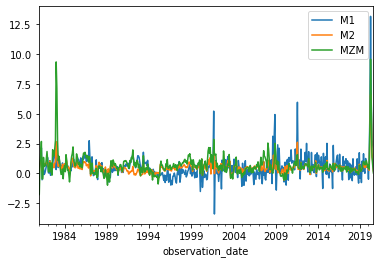

In [524]:
split_date = datetime.datetime(2008,11,1)
d_Monetary_diff = preprocessMonAgg(split_date,method=1)
d_Monetary_diff.plot()

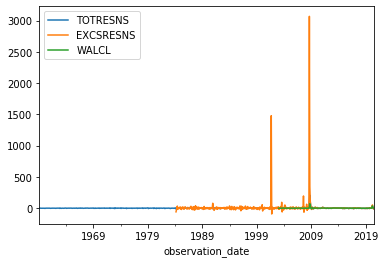

In [525]:
d_assets_diff = preprocess_assets(split_date,method=1)
d_assets_diff.plot()

Parse progress: |█████████████████████████████████████████████████████████| 100%
glrm Model Build progress: |██████████████████████████████████████████████| 100%
glrm prediction progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glrm Model Build progress: |██████████████████████████████████████████████| 100%
glrm prediction progress: |███████████████████████████████████████████████| 100%


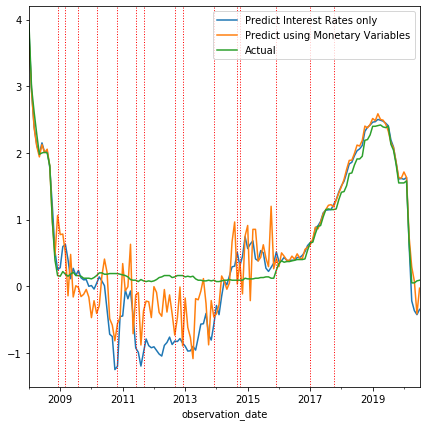

In [589]:
split_date = datetime.datetime(2008,11,1)
model(d_interest,split_date,method=1)

#### Method 2: Normalizaing assets,balance sheet items by calculating a Z-score based on data as on split date

In [22]:
split_date = datetime.datetime(2008,11,1)
d_Monetary_diff = preprocessMonAgg(split_date,method=2)
d_Monetary_diff.plot()

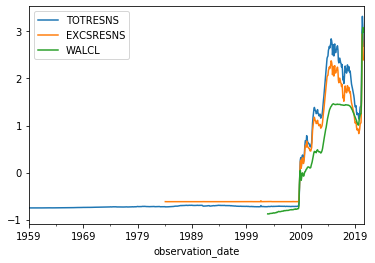

In [25]:
d_assets_diff = preprocess_assets(split_date,method=2)
d_assets_diff.plot()

In [13]:
split_date = datetime.datetime(2008,11,1)
d_int,d_mon = model(d_interest,split_date,method=2)

Parse progress: |█████████████████████████████████████████████████████████| 100%
glrm Model Build progress: |██████████████████████████████████████████████| 100%
glrm prediction progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glrm Model Build progress: |██████████████████████████████████████████████| 100%
glrm prediction progress: |███████████████████████████████████████████████| 100%


### Split Date: Jan-2010

#### Method 1:

In [28]:
split_date = datetime.datetime(2010,1,1)
model(d_interest,split_date)

Parse progress: |█████████████████████████████████████████████████████████| 100%
glrm Model Build progress: |██████████████████████████████████████████████| 100%
glrm prediction progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glrm Model Build progress: |██████████████████████████████████████████████| 100%
glrm prediction progress: |███████████████████████████████████████████████| 100%


#### Method 2:

Parse progress: |█████████████████████████████████████████████████████████| 100%
glrm Model Build progress: |██████████████████████████████████████████████| 100%
glrm prediction progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glrm Model Build progress: |██████████████████████████████████████████████| 100%
glrm prediction progress: |███████████████████████████████████████████████| 100%


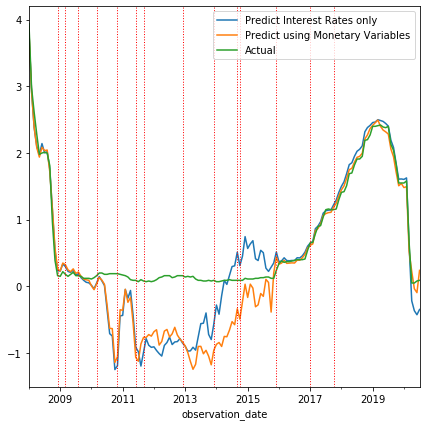

In [29]:
model(d_interest,split_date,method=2)

### Split Date: Jan-2012

#### Method 1:

In [30]:
split_date = datetime.datetime(2012,1,1)
model(d_interest,split_date,method=1)

Parse progress: |█████████████████████████████████████████████████████████| 100%
glrm Model Build progress: |██████████████████████████████████████████████| 100%
glrm prediction progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glrm Model Build progress: |██████████████████████████████████████████████| 100%
glrm prediction progress: |███████████████████████████████████████████████| 100%


In [31]:
model(d_interest,split_date,method=2)

Parse progress: |█████████████████████████████████████████████████████████| 100%
glrm Model Build progress: |██████████████████████████████████████████████| 100%
glrm prediction progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glrm Model Build progress: |██████████████████████████████████████████████| 100%
glrm prediction progress: |███████████████████████████████████████████████| 100%


### Split Date: Mar 2014

In [34]:
split_date = datetime.datetime(2014,1,1)
model(d_interest,split_date,method=1)

Parse progress: |█████████████████████████████████████████████████████████| 100%
glrm Model Build progress: |██████████████████████████████████████████████| 100%
glrm prediction progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glrm Model Build progress: |██████████████████████████████████████████████| 100%
glrm prediction progress: |███████████████████████████████████████████████| 100%


#### Method 2:

In [35]:
model(d_interest,split_date,method=2)

Parse progress: |█████████████████████████████████████████████████████████| 100%
glrm Model Build progress: |██████████████████████████████████████████████| 100%
glrm prediction progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glrm Model Build progress: |██████████████████████████████████████████████| 100%
glrm prediction progress: |███████████████████████████████████████████████| 100%


### Split Date: Jan-2016

#### Method 1:

Parse progress: |█████████████████████████████████████████████████████████| 100%
glrm Model Build progress: |██████████████████████████████████████████████| 100%
glrm prediction progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glrm Model Build progress: |██████████████████████████████████████████████| 100%
glrm prediction progress: |███████████████████████████████████████████████| 100%


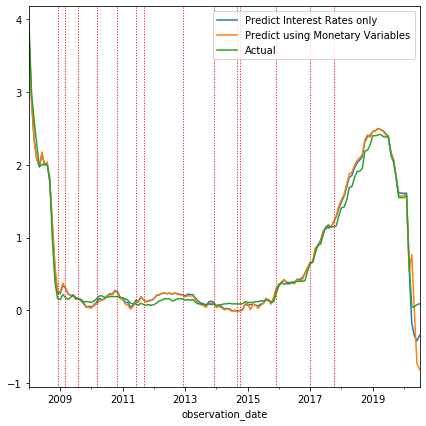

In [36]:
split_date = datetime.datetime(2016,1,1)
model(d_interest,split_date,method=1)

#### Method 2:

Parse progress: |█████████████████████████████████████████████████████████| 100%
glrm Model Build progress: |██████████████████████████████████████████████| 100%
glrm prediction progress: |███████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glrm Model Build progress: |██████████████████████████████████████████████| 100%
glrm prediction progress: |███████████████████████████████████████████████| 100%


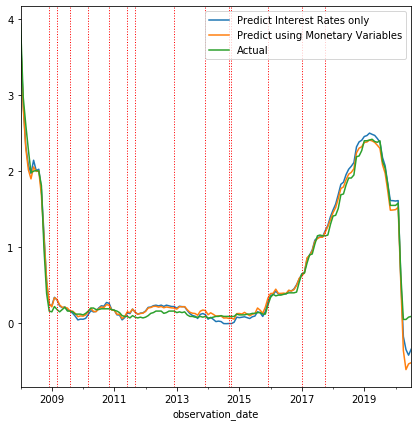

In [37]:
model(d_interest,split_date,method=2)

### PCA

In [22]:
def plot_expVariance(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
def plot_weights(pca,n_comp,columns):
    feature_weights = pca.components_
    fig, ax = plt.subplots(n_comp,1,figsize=(15,20))
    for i in range(n_comp): 
        ax[i].bar(columns,feature_weights[i])
        ax[i].set_title(label="PC_"+str(i+1))
        
def plot_kfFit(kf_model):
    kf_model.plot_fit(figsize=(15,15))
    
def plot_pca_df(df_int,df_monetary,df_orig,cutoff_date):
    df_int[df_int.index>=cutoff_date]['interest_only'].plot()
    df_monetary[df_monetary.index>=cutoff_date]['monetary_factors'].plot()
    df_orig[df_orig.index>=cutoff_date]['FEDFUNDS'].plot()
    plot_fed()
    plt.legend()

def plot_df(df,df_orig,cutoff_date):
    df['y_oos_kf'].plot()
    df_orig[df_orig.index>=cutoff_date]['FEDFUNDS'].plot()
    plt.legend()
    
def plot_kf_states(kf_states,kf_states_se):
    for i in kf_states.columns:
        plt.plot(kf_states[i],  lw=2)
        plt.fill_between(kf_states.index, kf_states[i]-2*kf_states_se[i], kf_states[i]+2*kf_states_se[i], alpha=0.1, facecolor='b')
        plt.title(i)
        plt.show()    

def calc_kalman(d_all_copy,n_comp,split_date):
    X = d_all_copy.iloc[:,1:]
    y = d_all_copy.iloc[:,:1]
    pca = PCA(n_components=n_comp)
    pca.fit(X)
    plot_expVariance(pca)
    X_pca = pca.transform(X)
    plot_weights(pca,n_comp,X.columns)
    cols = []
    for i in range(1,X_pca.shape[1]+1):
        cols.append("PC"+str(i))
    X_pca = pd.DataFrame(X_pca,columns=cols,index=X.index)
    df_pca = y.merge(X_pca,left_index=True,right_index=True,how='inner')
    df_pca_train = df_pca.loc[df_pca.index<=split_date]
    df_pca_test = df_pca.loc[df_pca.index>split_date]
    reg = "FEDFUNDS ~ "+"+".join(cols)
    kf_model = pf.DynReg(reg, data=df_pca_train)
    kf_fit = kf_model.fit(method='PML')
    z = kf_model.latent_variables.get_z_values()
    d = kf_model.data
    kf_b_t, kf_V_t = kf_model.smoothed_state(d,z)
    # Create smoothed/filtered aggregate series
    _, Z, _, _, _ = kf_model._ss_matrices(kf_model.latent_variables.get_z_values())
    kf_smoothed_series = np.zeros(kf_model.y.shape[0])
    for t in range(0,kf_model.y.shape[0]):
        kf_smoothed_series[t] = np.dot(Z[t],kf_b_t[:,t])
    kf_resid = pd.DataFrame((kf_model.data[10:] - kf_smoothed_series[10:]))
    kf_b_t = pd.DataFrame(kf_b_t).T
                                                                                                           
    kf_states = pd.DataFrame(kf_fit.states[:,10:-1]).T
    kf_states.columns = ['b'+str(i) for i in range(kf_states.shape[1])]
    kf_states_se = pd.DataFrame(kf_fit.states_var[0,0][10:-1]**.5)
    for i in range(1,n_comp+1):
        kf_states_se[str(i)] = kf_fit.states_var[i,i][10:-1]**.5
    kf_states_se.columns = ['b'+str(i) for i in range(kf_states.shape[1])]
    plot_kf_states(kf_states,kf_states_se)
    plot_kfFit(kf_model)  
                                                                                                           
    ### OOS Forecast
    a_kf = kf_states.iloc[-1][0]
    b_kf = kf_states.iloc[-1][1:]
    X = df_pca[cols].to_numpy()
    df_pca['y_oos_kf'] = pd.DataFrame(a_kf + np.dot(X,b_kf), index=df_pca.index)    
    
    return df_pca

In [23]:
def kalman_pca(df_orig,method,n_comp,split_date=datetime.datetime(2008,11,1),cutoff_date=datetime.datetime(2000,1,1),fill=0.0,interestOnly=True):
    d_assets_diff = preprocess_assets(split_date,method=method)
    d_Monetary_diff = preprocessMonAgg(split_date,method=method)
    d_interest_copy = preprocess(d_interest,split_date)
    if interestOnly:
        d_interest_copy = d_interest_copy.loc[d_interest_copy.index>datetime.datetime(2000,1,1)]
        d_interest_copy.fillna(fill,inplace=True)
        df = calc_kalman(d_interest_copy,n_comp,split_date)
        df.rename(columns={'y_oos_kf':'interest_only'},inplace=True)
    else:
        d_all = pd.concat([d_interest_copy,d_Monetary_diff,d_assets_diff],axis=1,join='inner')
        d_all.fillna(fill,inplace=True)
        d_all_copy = d_all.copy(deep=True)
        d_all_copy = d_all_copy.loc[d_all_copy.index>datetime.datetime(2000,1,1)]
        df = calc_kalman(d_all_copy,n_comp,split_date)
        df.rename(columns={'y_oos_kf':'monetary_factors'},inplace=True)
    return df                                                                                                       
                                                                                                           

### PCA Kalman

#### Method 1:

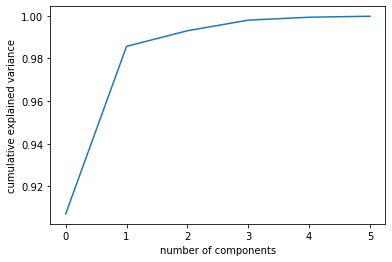

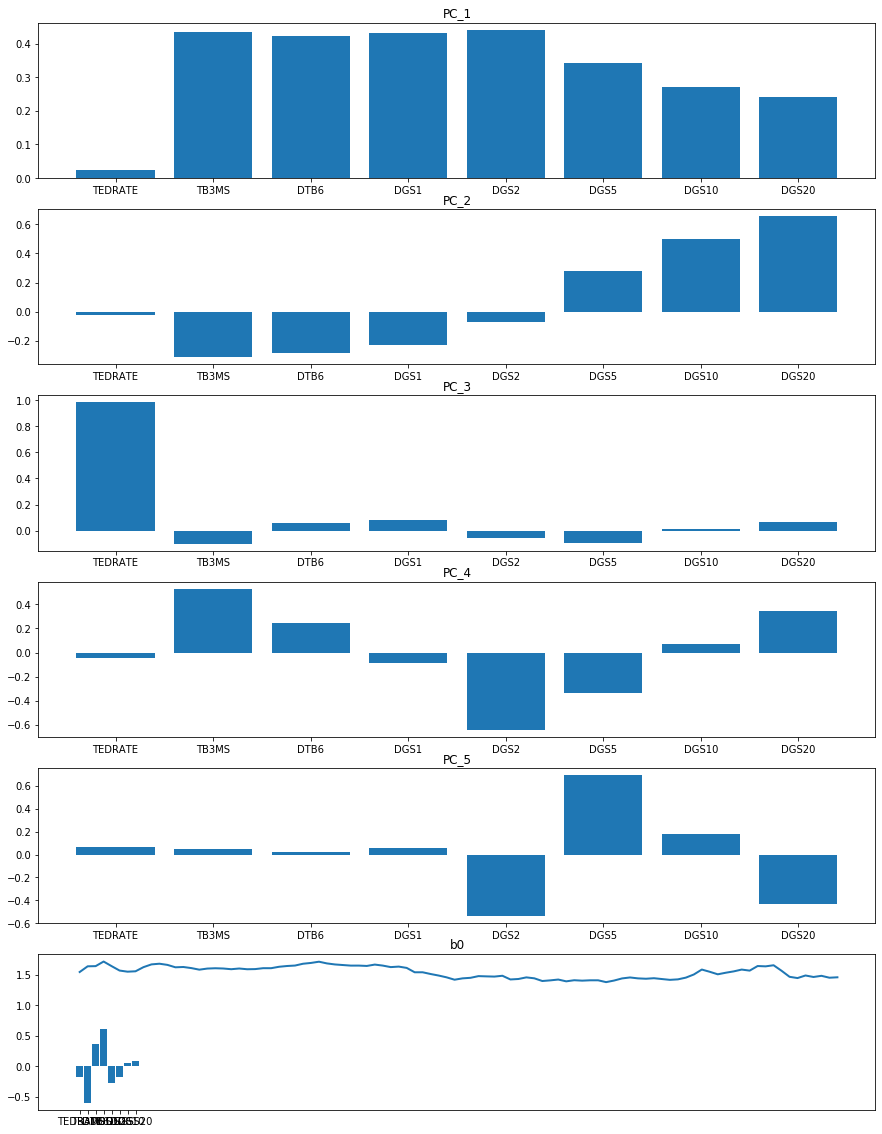

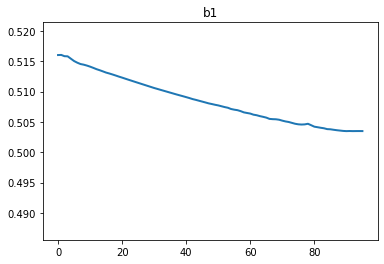

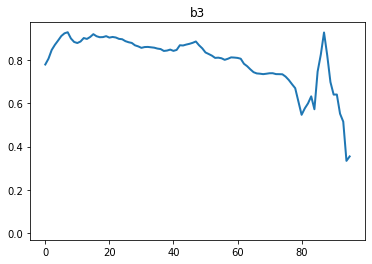

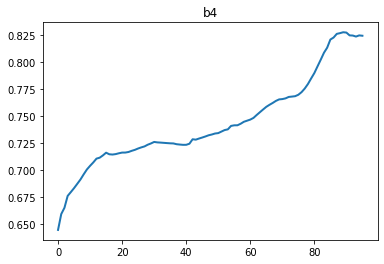

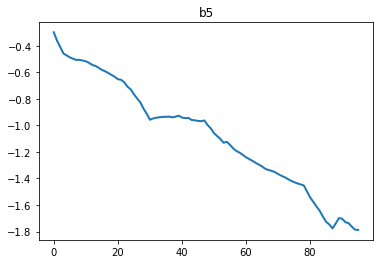

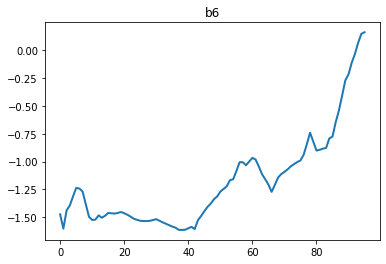

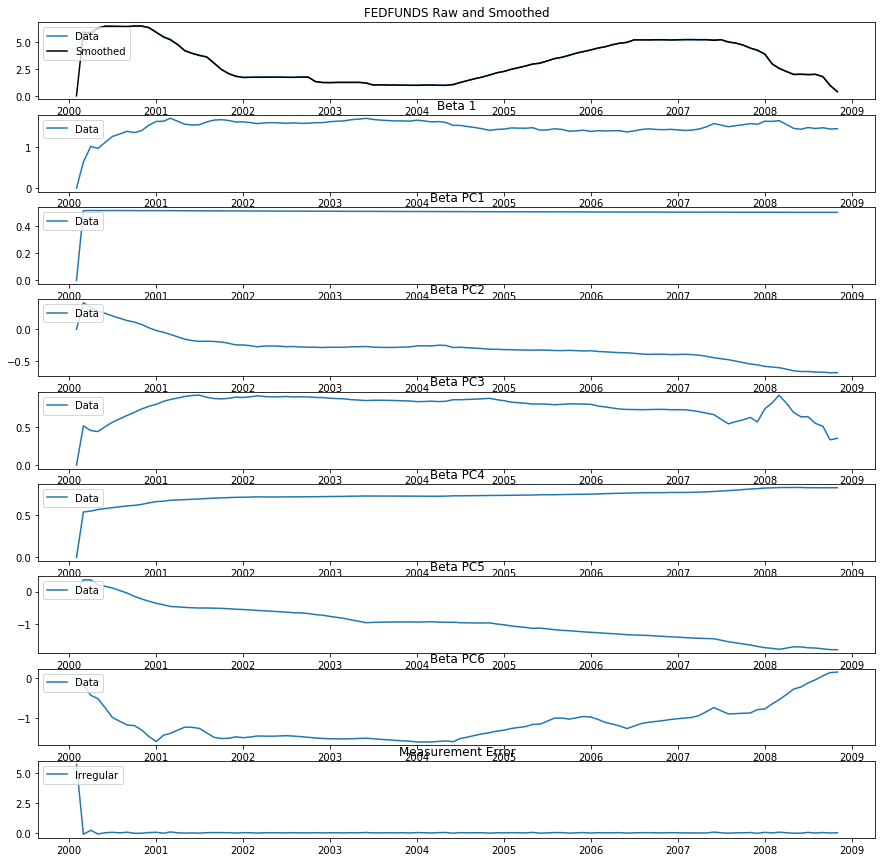

In [17]:
df_int = kalman_pca(d_interest,1,6,split_date=datetime.datetime(2008,11,1),interestOnly=True)

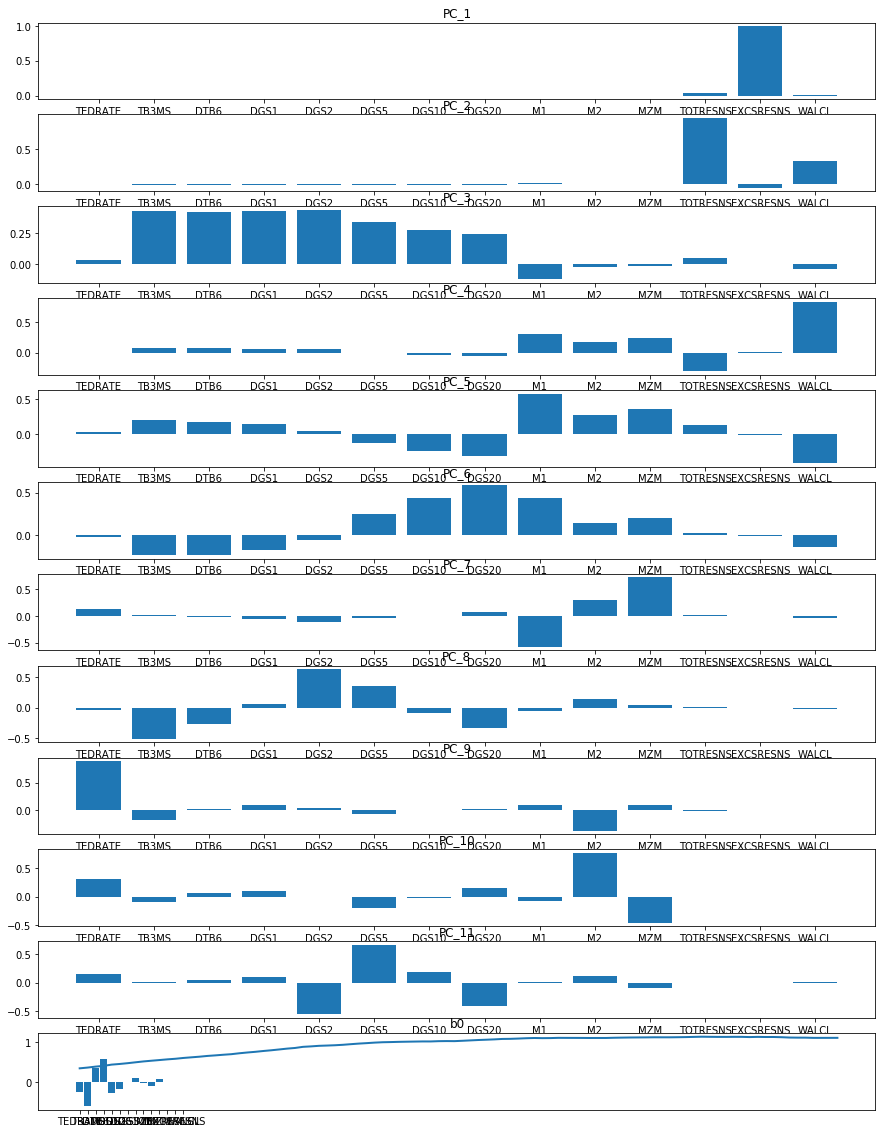

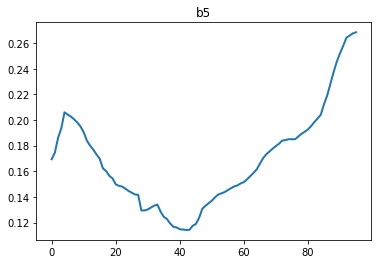

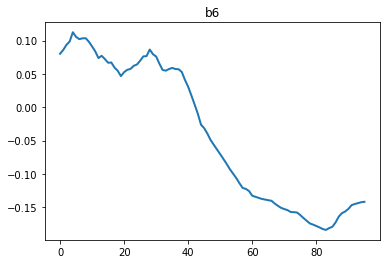

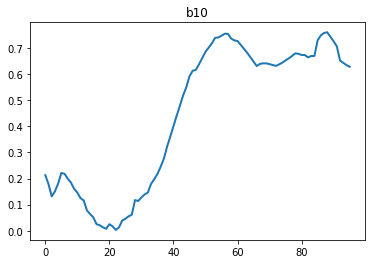

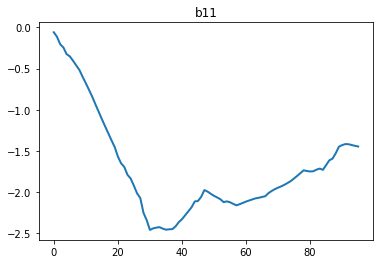

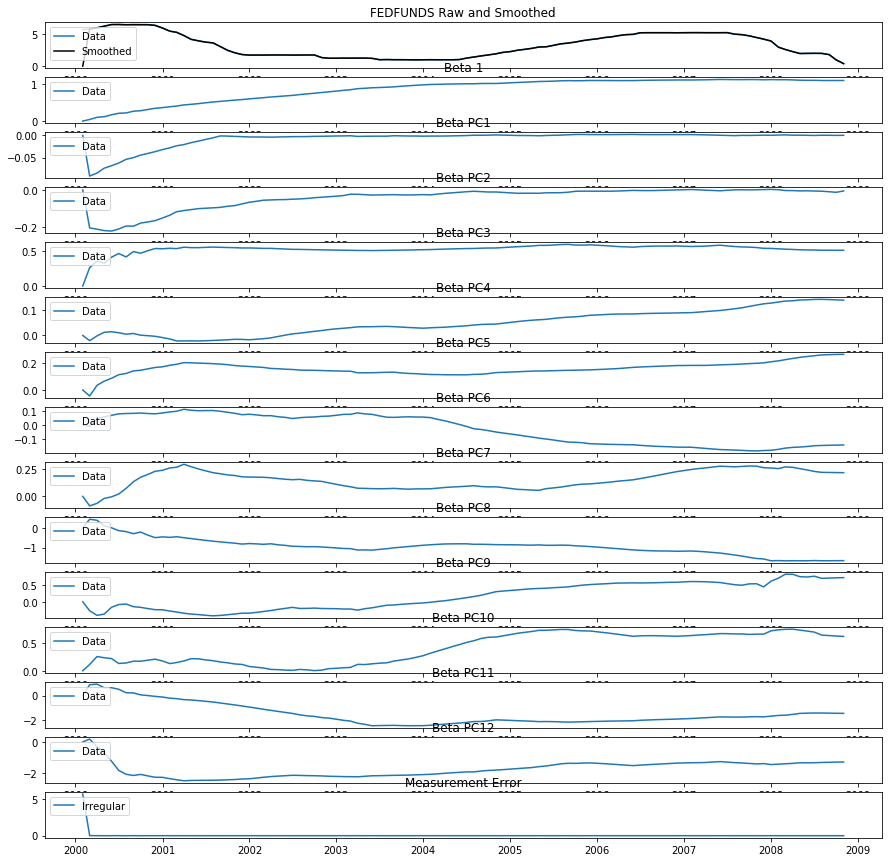

In [18]:
df_monetary = kalman_pca(d_interest,1,12,split_date=datetime.datetime(2008,11,1),interestOnly=False)

In [19]:
cutoff_date = datetime.datetime(2000,1,1)
plot_pca_df(df_int,df_monetary,d_interest,cutoff_date)

### Method 2:

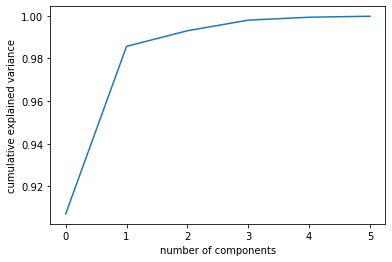

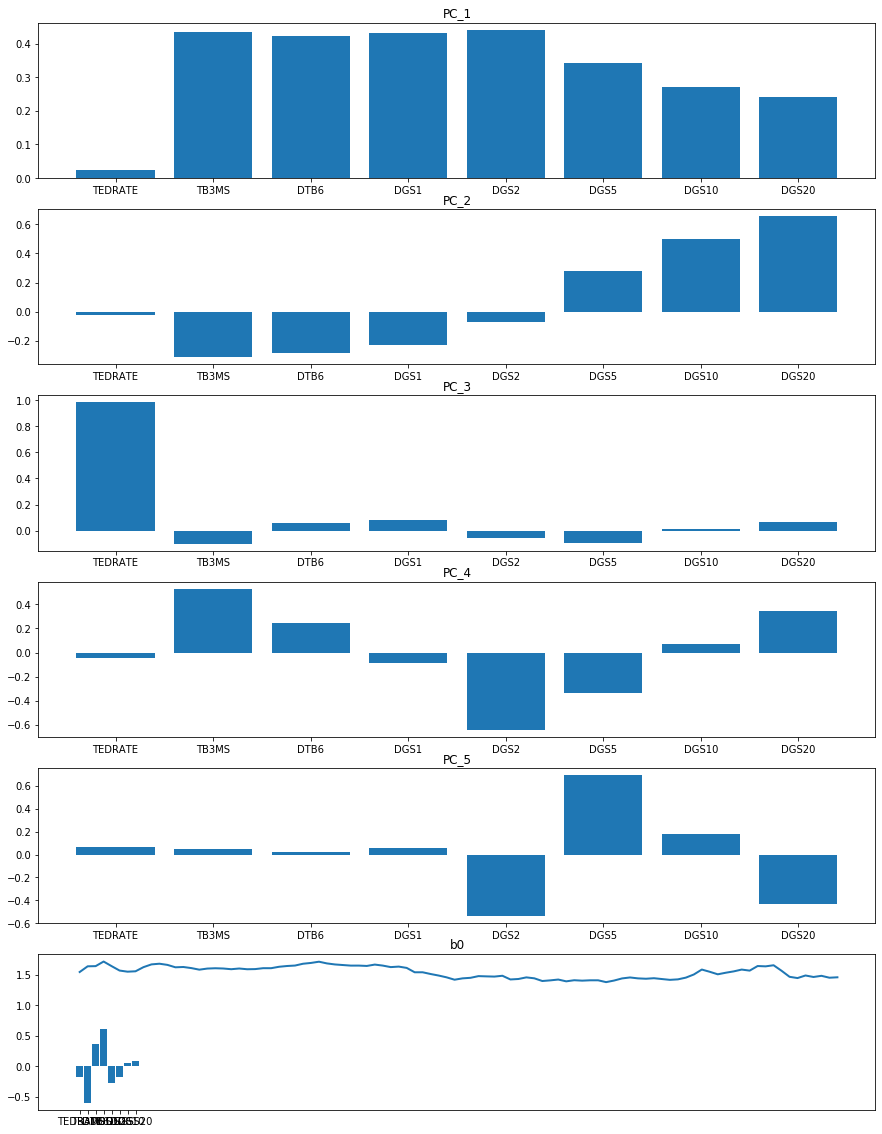

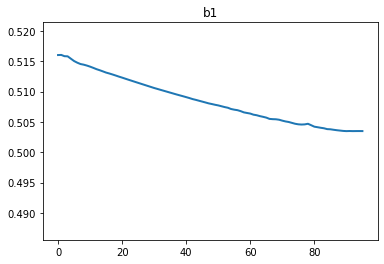

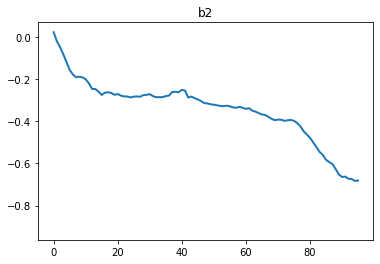

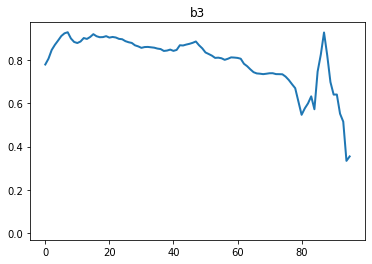

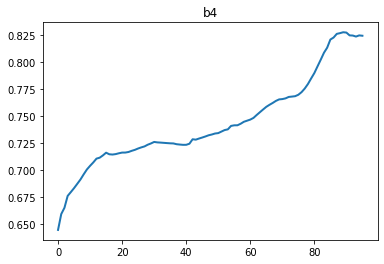

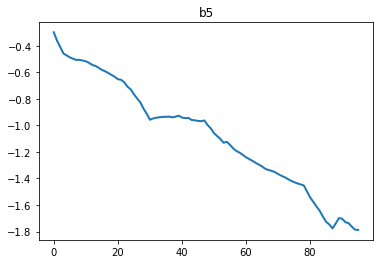

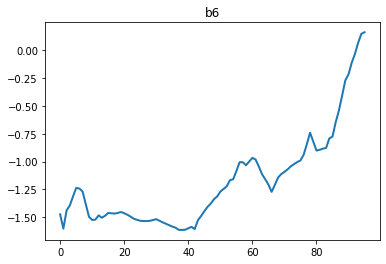

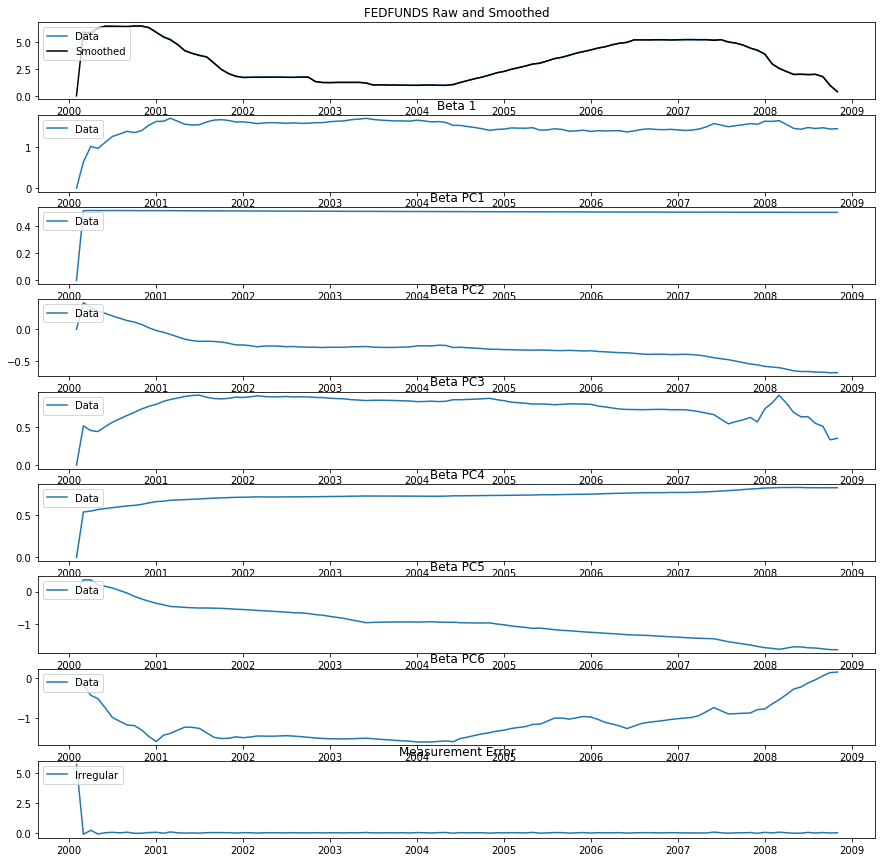

In [24]:
df_int = kalman_pca(d_interest,2,6,split_date=datetime.datetime(2008,11,1),interestOnly=True)

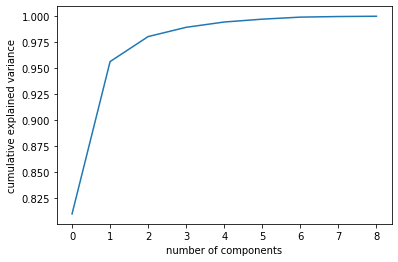

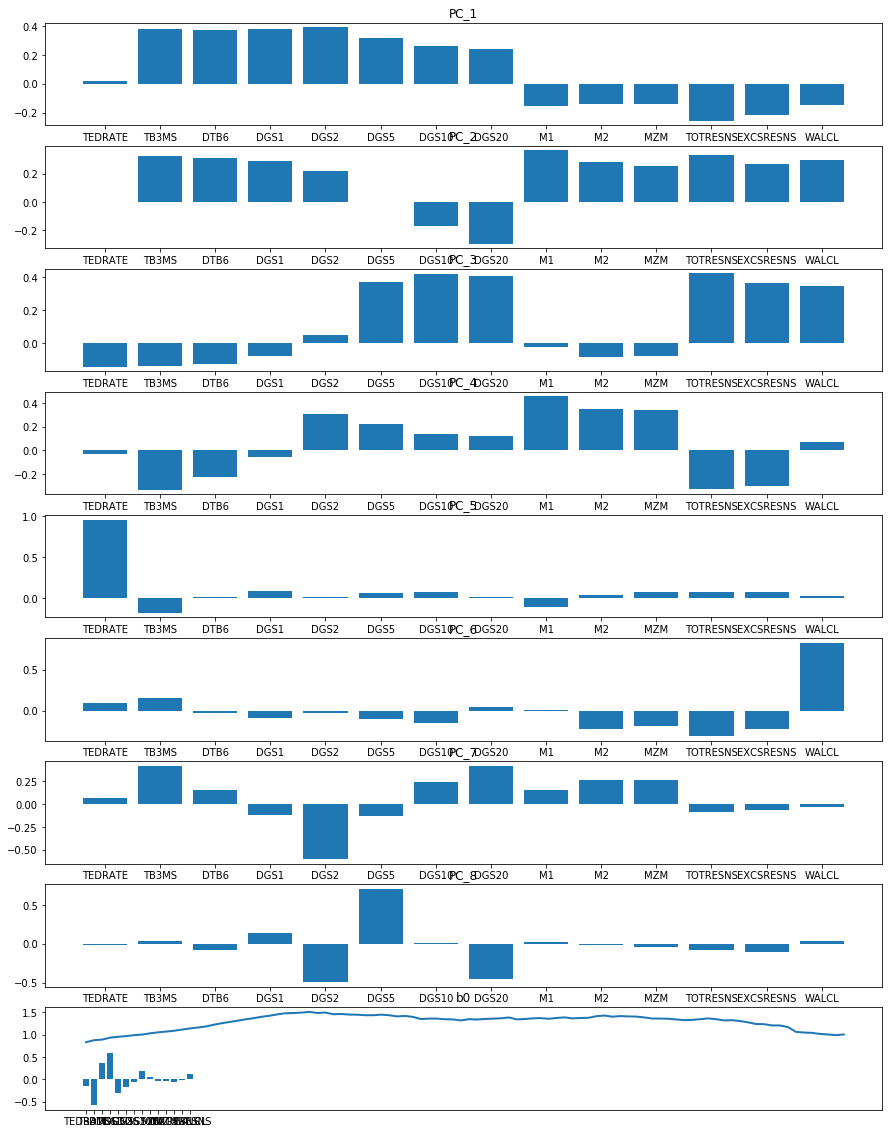

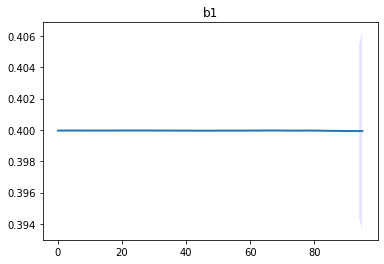

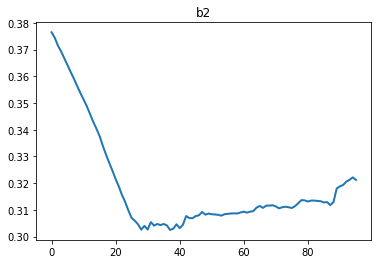

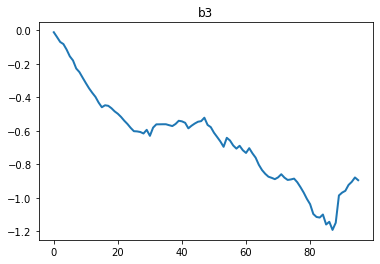

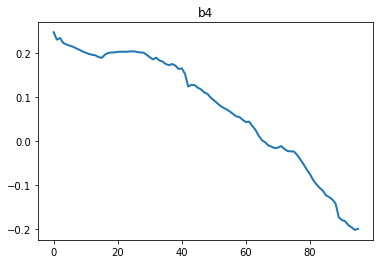

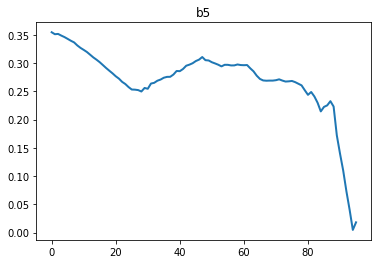

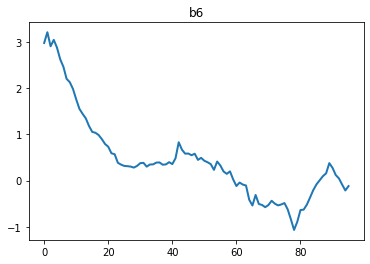

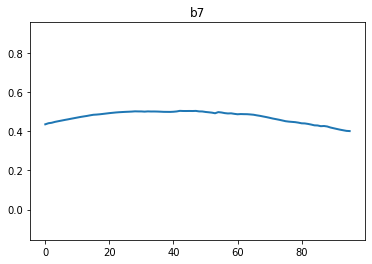

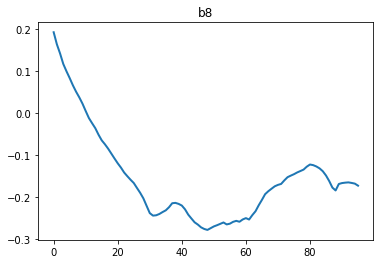

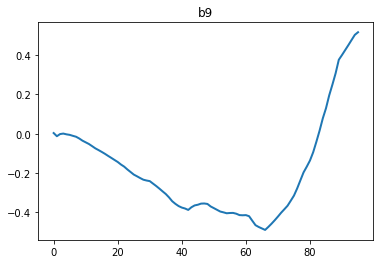

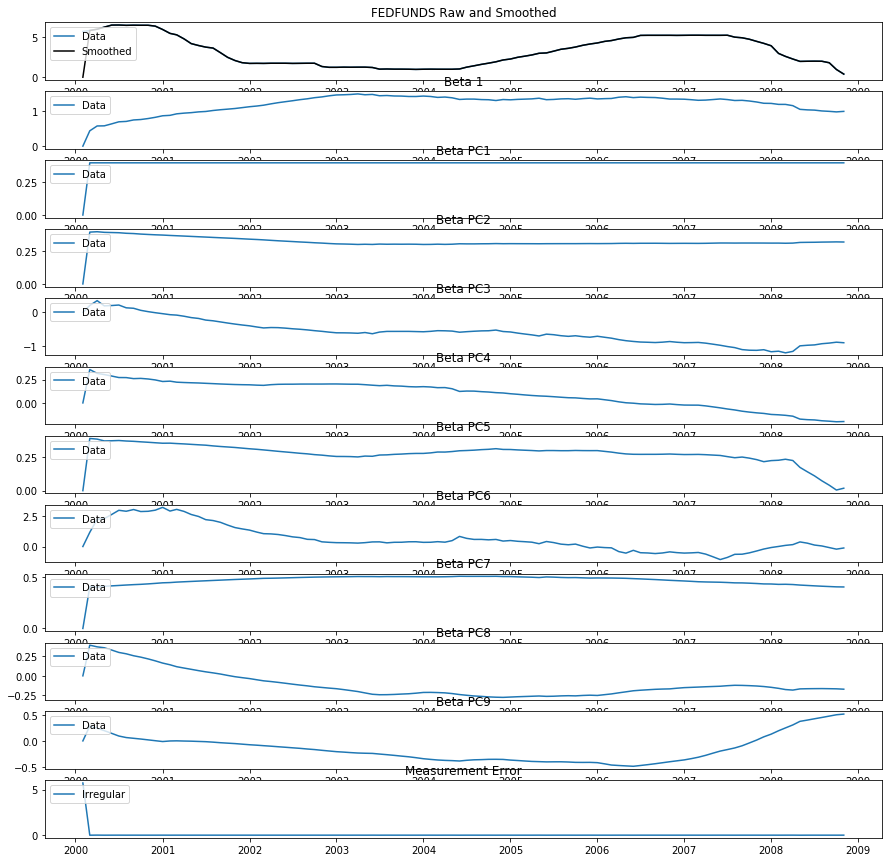

In [25]:
df_monetary = kalman_pca(d_interest,2,9,split_date=datetime.datetime(2008,11,1),interestOnly=False)

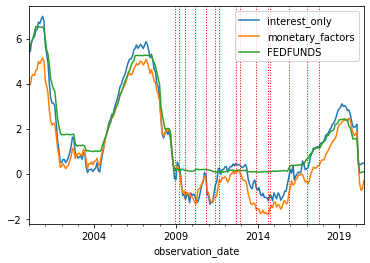

In [26]:
cutoff_date = datetime.datetime(2000,1,1)
plot_pca_df(df_int,df_monetary,d_interest,cutoff_date)